In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans as KM
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn import preprocessing

In [4]:
#load data
categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset = 'all', categories = categories,  shuffle=True,random_state=42)
vectorizer=CountVectorizer(min_df=3,stop_words='english')
tfidf_transformer = TfidfTransformer(smooth_idf=False)  
X=vectorizer.fit_transform(dataset['data'])
X_tfidf=tfidf_transformer.fit_transform(X)
print(X_tfidf.shape)
clf=KM(n_clusters=2, n_init=30, max_iter=1000, random_state=0, n_jobs=-1)
#pred=clf.fit_predict(X_tfidf)
#np.save('cluster prediction',pred)
pred=np.load('cluster prediction.npy')

(7882, 27768)


In [5]:
labels=dataset['target'].copy()
labels[np.where(labels<=3)]=1
labels[np.where(labels>3)]=0
print(contingency_matrix(labels,pred))

report_scores=lambda labels,pred: np.array([homogeneity_score(labels,pred),completeness_score(labels,pred),
                                          v_measure_score(labels,pred),adjusted_rand_score(labels,pred),
                                          adjusted_mutual_info_score(labels,pred)])

print_scores=lambda labels,pred: ('homogeneity score: {:.4f}, completeness score: {:.4f}, V-measure: {:.4f}, adjusted Rand score: {:.4f}, adjusted mutual info score: {:.4f}'.
      format(*report_scores(labels,pred)))

[[1727 2252]
 [   4 3899]]


Text(0,0.5,'percentage of variance')

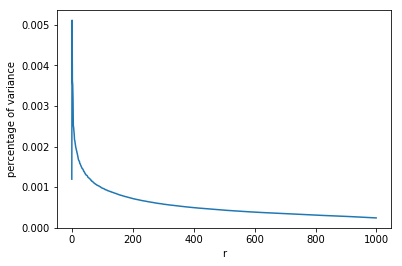

In [4]:
svd = TruncatedSVD(n_components=1000, random_state=0)
X_reduced = svd.fit_transform(X_tfidf)
plt.plot(svd.explained_variance_ratio_)
plt.xlabel('r')
plt.ylabel('percentage of variance')

In [5]:
def plot_5_scores(scores,title):
    score_names=['homogeneity','completeness','V-measure','adjusted Rand','adjusted mutual info']
    fig,ax=plt.subplots(1,5,figsize=(16,3))
    for i in range(5):
        ax[i].plot(r_list,scores[:,i])
        ax[i].set_xlabel('r')
        ax[i].set_xlim(0,50)
        ax[i].set_ylim(0,1)
        ax[i].set_title(title+', '+score_names[i])
        
best_r=lambda scores: print('best r is: {:}'.format([r_list[k] for k in np.argmax(scores,axis=0)]))

best r is: [2, 2, 2, 2, 2]


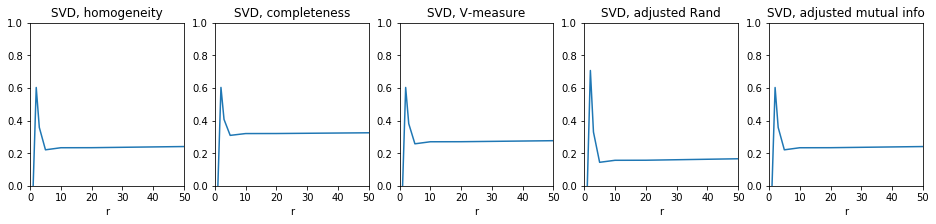

In [6]:
r_list=[1,2,3,5,10,20,50,100,300]
scores_svd=[]
for r in r_list:
    pred=clf.fit_predict(X_reduced[:,:r])
    scores_svd.append(report_scores(labels,pred))
scores_svd=np.array(scores_svd)        
plot_5_scores(scores_svd,'SVD')
best_r(scores_svd)

best r is: [2, 2, 2, 2, 2]


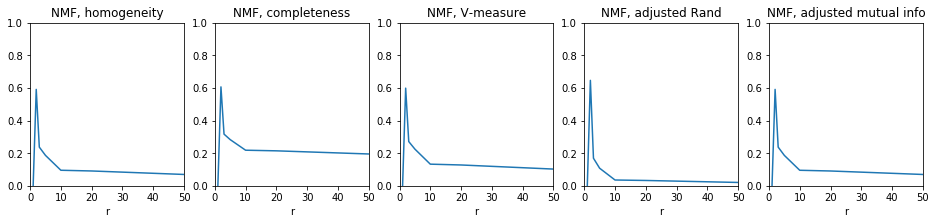

In [7]:
scores_nmf=[]
for r in r_list:
    nmf = NMF(n_components=r, init='random', random_state=0)
    X_nmf = nmf.fit_transform(X_tfidf)
    pred=clf.fit_predict(X_nmf)
    scores_nmf.append(report_scores(labels,pred))
scores_nmf=np.array(scores_nmf)
plot_5_scores(scores_nmf,'NMF')
best_r(scores_nmf)

In [8]:
X_svd=TruncatedSVD(n_components=2, random_state=0).fit_transform(X_tfidf)
pred_svd=clf.fit_predict(X_svd)
X_nmf=NMF(n_components=2, init='random', random_state=0).fit_transform(X_tfidf)
pred_nmf=clf.fit_predict(X_nmf)

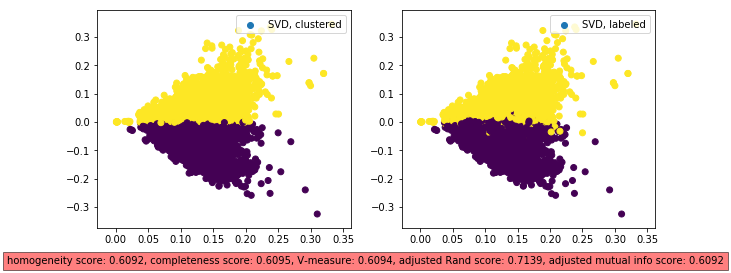

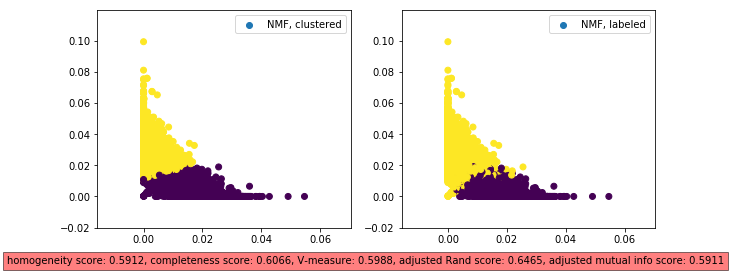

In [63]:
def visualize_clustering(X,labels,pred,label):
    fig,axes=plt.subplots(1,2,figsize=(10,4))
    axes[0].scatter(X[:,0],X[:,1],c=pred,label=label+', clustered')
    axes[0].legend(loc="upper right")
    axes[1].scatter(X[:,0],X[:,1],c=labels,label=label+', labeled')
    axes[1].legend(loc="upper right")
    fig.text(0,0,print_scores(labels,pred),bbox=dict(facecolor='red', alpha=0.5))
    
visualize_clustering(X_svd,labels,pred_svd,'SVD')
visualize_clustering(X_nmf,labels,pred_nmf,'NMF')

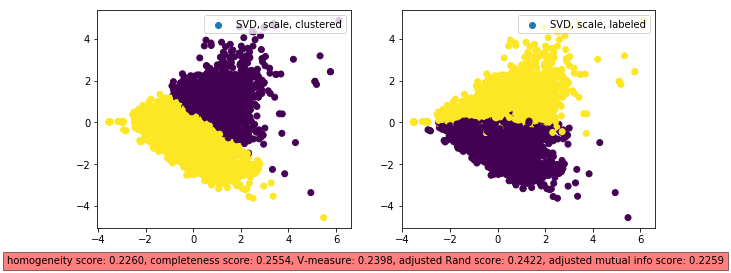

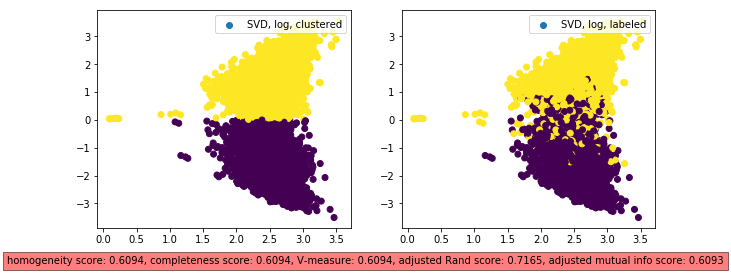

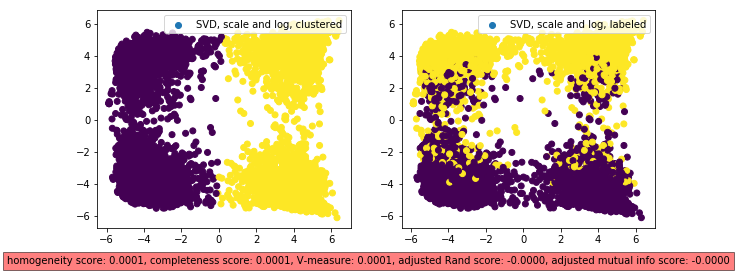

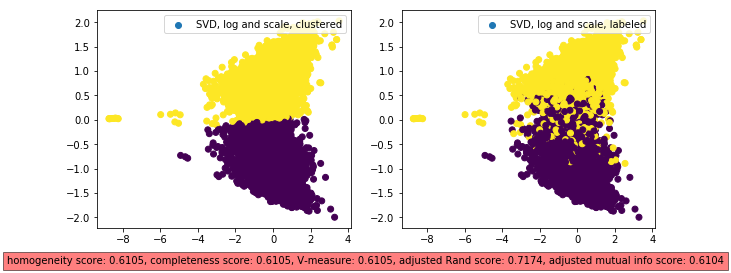

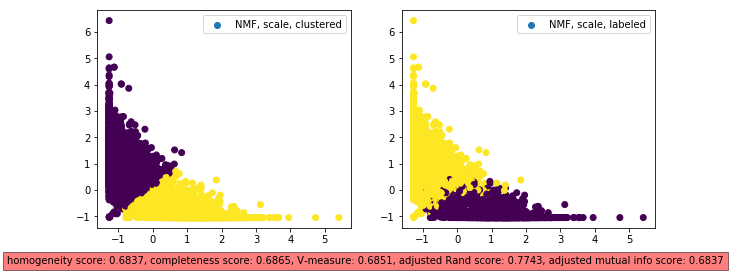

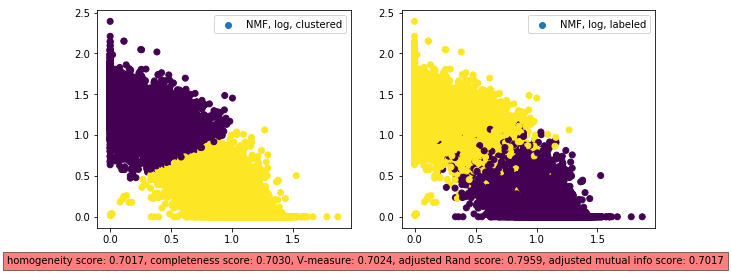

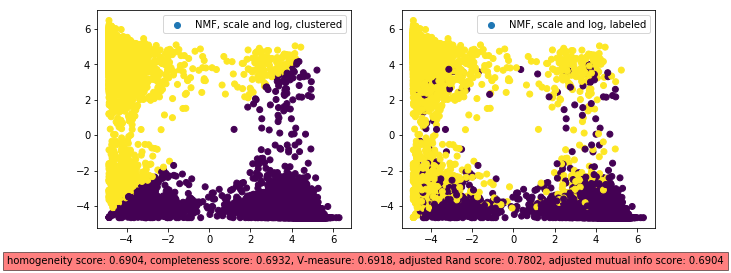

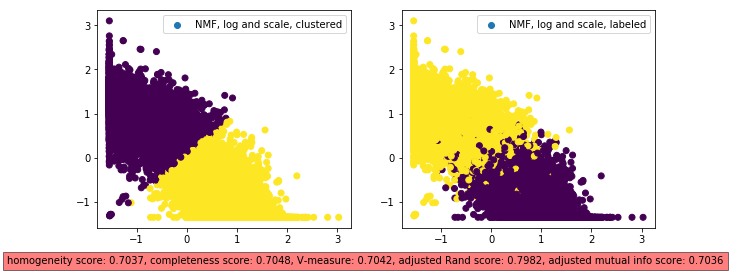

In [65]:
c=0.01
log_transform=lambda x: np.multiply(np.sign(x),(np.log(np.absolute(x)+c)-np.log(c)))
def preprocess_combo(X):
    X_scaled=preprocessing.scale(X)
    X_log=log_transform(X)
    X_scaled_log=log_transform(preprocessing.scale(X))
    X_log_scaled=preprocessing.scale(log_transform(X))
    return [X_scaled,X_log,X_scaled_log,X_log_scaled]

preprocess_list=['scale','log','scale and log','log and scale']
for i,X in enumerate(preprocess_combo(X_svd)):
    pred=clf.fit_predict(X)
    visualize_clustering(X,labels,pred,'SVD, '+preprocess_list[i])  
    
for i,X in enumerate(preprocess_combo(X_nmf)):
    pred=clf.fit_predict(X)
    visualize_clustering(X,labels,pred,'NMF, '+preprocess_list[i])  

In [105]:
dataset_all = fetch_20newsgroups(subset = 'all', shuffle=True,random_state=42)
vectorizer=CountVectorizer(min_df=3,stop_words='english')
tfidf_transformer = TfidfTransformer(smooth_idf=False)  
X_all=vectorizer.fit_transform(dataset_all['data'])
X_all_tfidf=tfidf_transformer.fit_transform(X_all)
print(X_all_tfidf.shape)
clf_all=KM(n_clusters=20, n_init=30, max_iter=1000, random_state=0, n_jobs=-1)
#pred_all=clf_all.fit_predict(X_all_tfidf)
#np.save('cluster prediction_20',pred_all)
pred_all=np.load('cluster prediction_20.npy')

(18846, 52295)


Text(-2,-1,'homogeneity score: 0.2985, completeness score: 0.3601, V-measure: 0.3264, adjusted Rand score: 0.1190, adjusted mutual info score: 0.2962')

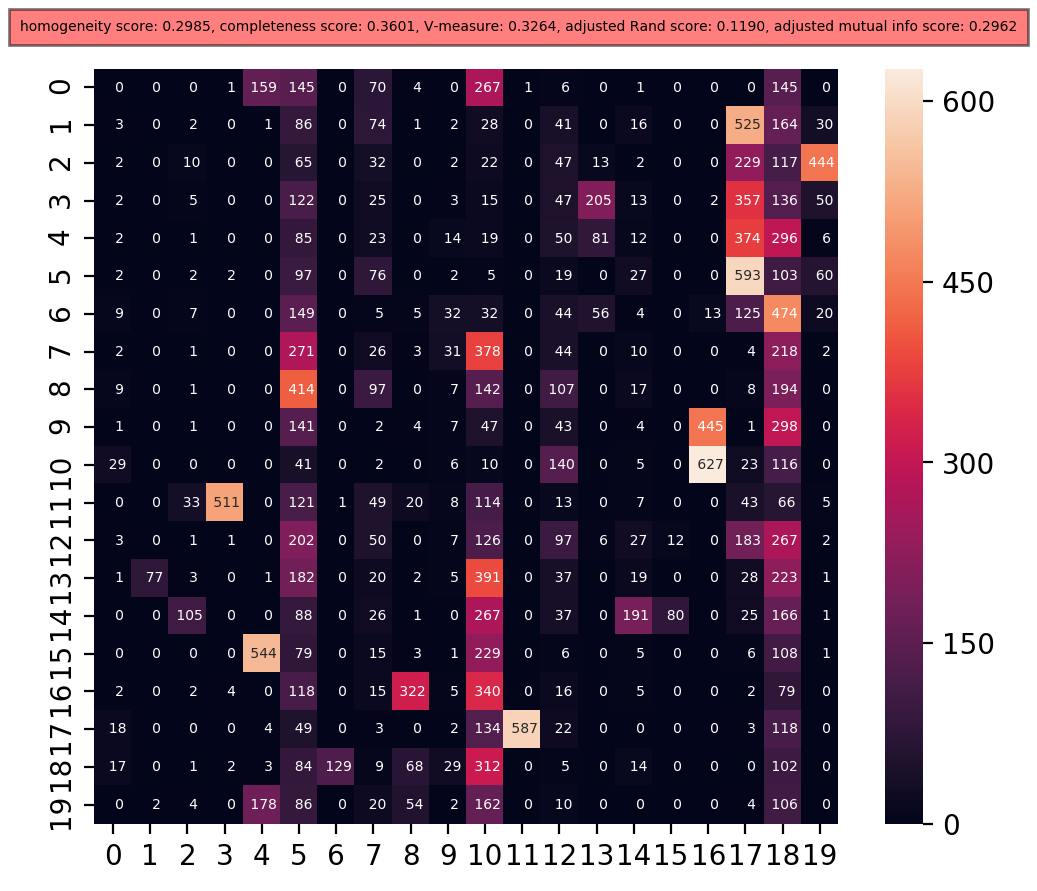

In [102]:
labels_all=dataset_all['target']
cm=pd.DataFrame(contingency_matrix(labels_all,pred_all))
plt.figure(figsize=(6,5),dpi=200)
sns.heatmap(cm,annot=True,annot_kws={"size": 5},fmt='4d')
plt.text(-2,-1,print_scores(labels_all,pred_all),bbox=dict(facecolor='red', alpha=0.5),fontsize=5)

best r is: [10, 300, 10, 10, 10]


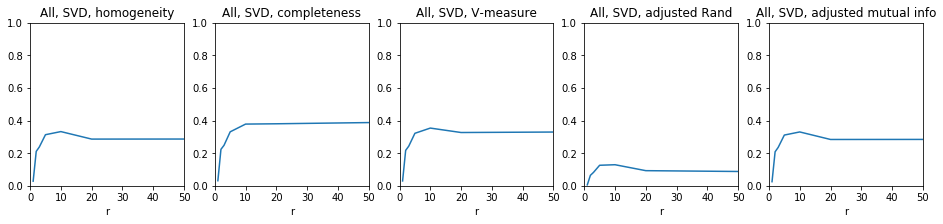

In [106]:
X_all_svd=TruncatedSVD(n_components=300, random_state=0).fit_transform(X_all_tfidf)
r_list=[1,2,3,5,10,20,50,100,300]
scores_all_svd=[]
for r in r_list:
    pred_all=clf_all.fit_predict(X_all_svd[:,:r])
    scores_all_svd.append(report_scores(labels_all,pred_all))
scores_all_svd=np.array(scores_all_svd)        
plot_5_scores(scores_all_svd,'All, SVD')
best_r(scores_all_svd)

best r is: [10, 10, 10, 10, 10]


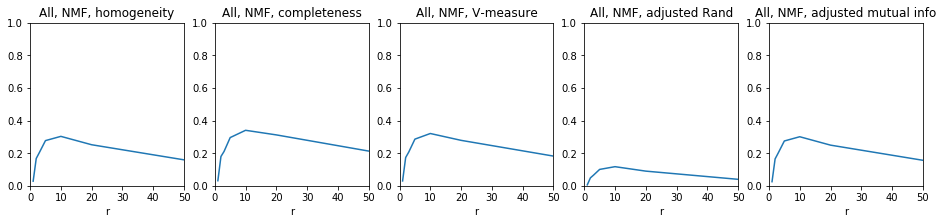

In [107]:
scores_all_nmf=[]
for r in r_list:
    nmf = NMF(n_components=r, init='random', random_state=0)
    X_all_nmf = nmf.fit_transform(X_all_tfidf)
    pred_all=clf_all.fit_predict(X_all_nmf)
    scores_all_nmf.append(report_scores(labels_all,pred_all))
scores_all_nmf=np.array(scores_all_nmf)
plot_5_scores(scores_all_nmf,'All, NMF')
best_r(scores_all_nmf)

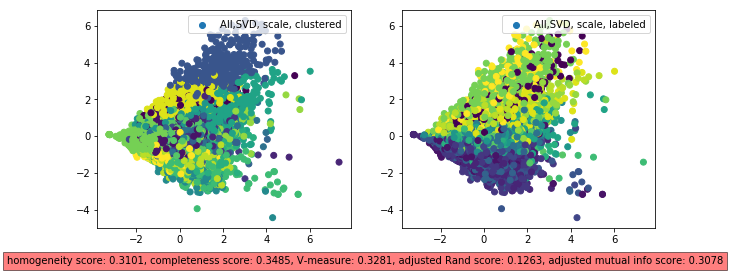

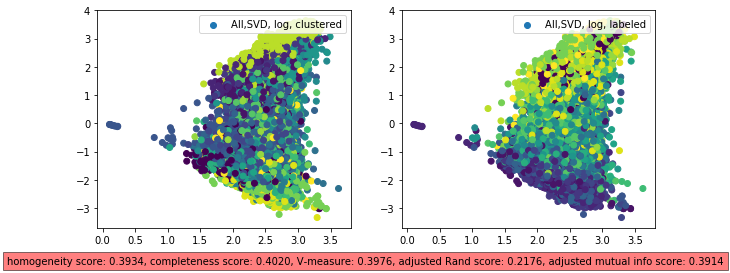

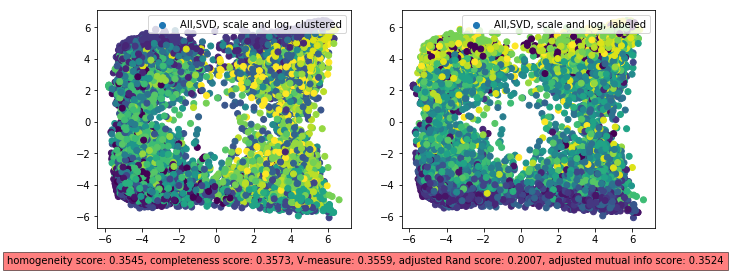

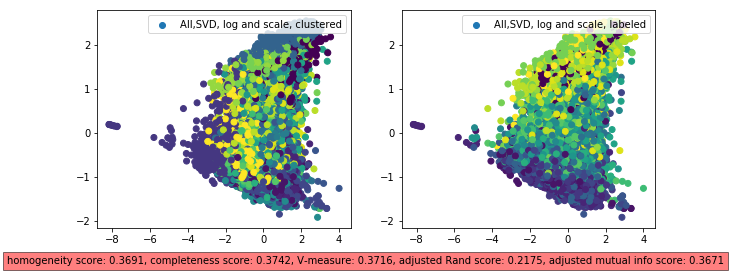

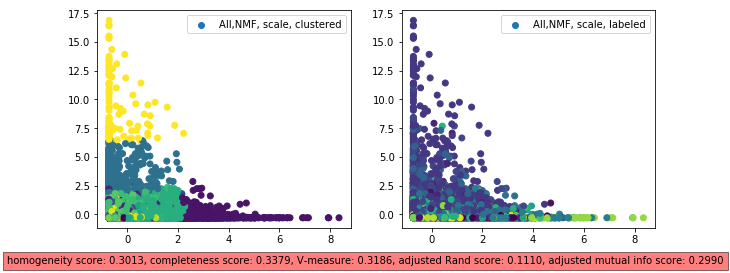

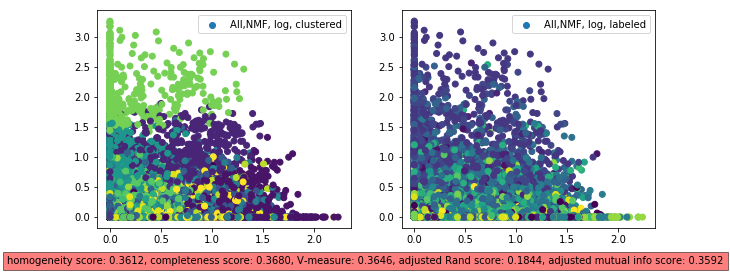

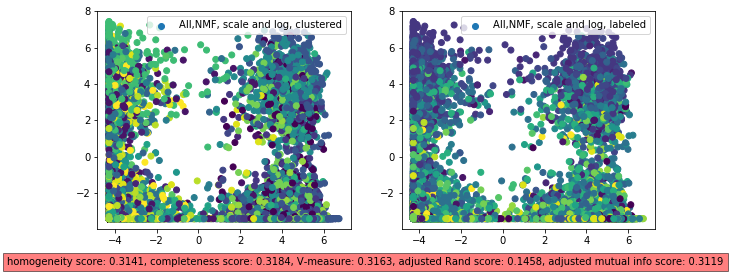

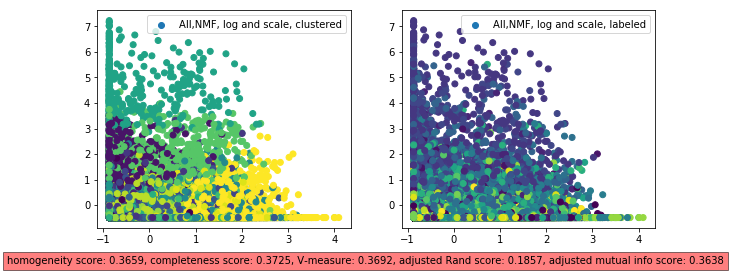

In [111]:
#so we choose to to dimension reduction down to 10
X_all_svd_10=X_all_svd[:,:10]
X_all_nmf_10=NMF(n_components=10, init='random', random_state=0).fit_transform(X_all_tfidf)

preprocess_list=['scale','log','scale and log','log and scale']
for i,X in enumerate(preprocess_combo(X_all_svd_10)):
    pred_all=clf_all.fit_predict(X)
    visualize_clustering(X[:,:2],labels_all,pred_all,'All,SVD, '+preprocess_list[i])  
    
for i,X in enumerate(preprocess_combo(X_all_nmf_10)):
    pred_all=clf_all.fit_predict(X)
    visualize_clustering(X[:,:2],labels_all,pred_all,'All,NMF, '+preprocess_list[i])  